In [62]:
from tqdm import tqdm
from prophet import Prophet
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [46]:
csv_file = r'C:\\Users\\bella\\Downloads\\Y2Q4 JBG050 Data Challenge 2\\total_barnet.csv'
total_csv = pd.read_csv(csv_file)
total_csv.drop(columns = ["Unnamed: 0"], inplace=True)
def get_coordinates(x): 
    coordinate = (x["latitude"], x["longitude"])
    return coordinate 

total_csv["coordinates"] = total_csv.apply(get_coordinates, axis=1)
total_csv.drop(columns = ["longitude"], inplace=True)
total_csv.drop(columns = ["latitude"], inplace=True)
total_csv.drop(columns = ["last_outcome_category"], inplace=True)
total_csv.drop(columns = ["lsoa_code"], inplace=True)
total_csv.drop(columns = ["lsoa_name"], inplace=True)
total_csv.drop(columns = ["ward_code"], inplace=True)

In [47]:
total_csv.head()

,crime_id,month,location,ward_name,coordinates
0,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,2010-12,On or near High Street,High Barnet,"(51.655538, -0.201877)"
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,2010-12,On or near The Avenue,High Barnet,"(51.654317, -0.207853)"
2,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,2010-12,On or near Bruce Road,High Barnet,"(51.656348, -0.20251)"
3,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,2010-12,On or near The Drive,High Barnet,"(51.654768, -0.206779)"
4,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,2010-12,On or near Marriott Road,High Barnet,"(51.655223, -0.209537)"


In [48]:
ward_csv = pd.DataFrame()
ward_csv['crimes'] = total_csv.groupby('month').count()['crime_id']
ward_csv['month'] = ward_csv.index
covid_years = ['2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07']
ward_csv = ward_csv.drop(covid_years)
# for index in ward_csv.index:
#      print(index)
ward_csv.head()
print(ward_csv)

         crimes    month
month                   
2010-12     372  2010-12
2011-01     486  2011-01
2011-02     403  2011-02
2011-03     408  2011-03
2011-04     414  2011-04
...         ...      ...
2022-11     246  2022-11
2022-12     228  2022-12
2023-01     242  2023-01
2023-02     199  2023-02
2023-03     231  2023-03

[139 rows x 2 columns]


In [49]:
ward_csv['month'] = pd.to_datetime(ward_csv['month'], format='%Y-%m-%d')
ward_csv.head()

,crimes,month
month,,
2010-12,372,2010-12-01
2011-01,486,2011-01-01
2011-02,403,2011-02-01
2011-03,408,2011-03-01
2011-04,414,2011-04-01


In [50]:
ward_csv = ward_csv.rename(columns={'month': 'ds',
                        'crimes': 'y'})

ward_csv.head()

,y,ds
month,,
2010-12,372,2010-12-01
2011-01,486,2011-01-01
2011-02,403,2011-02-01
2011-03,408,2011-03-01
2011-04,414,2011-04-01


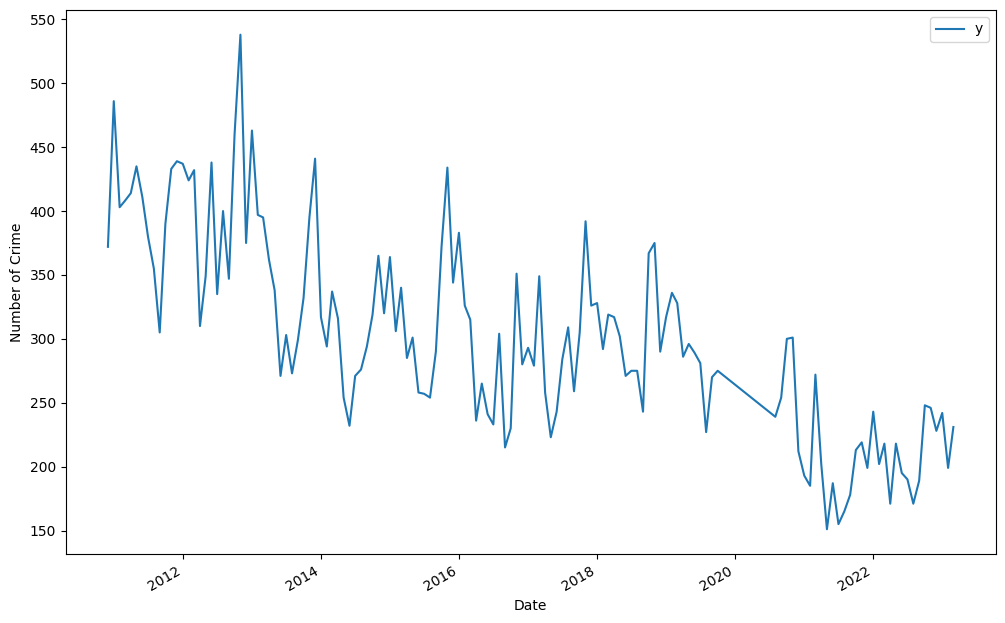

In [51]:
ax = ward_csv.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Number of Crime')
ax.set_xlabel('Date')

plt.show()

In [165]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet()
model.fit(ward_csv)

20:34:23 - cmdstanpy - INFO - Chain [1] start processing
20:34:23 - cmdstanpy - INFO - Chain [1] done processing


- ds: the datestamp of the forecasted value
- yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- yhat_lower: the lower bound of our forecasts
- yhat_upper: the upper bound of our forecasts

In [166]:
# model.plot(forecast1, uncertainty=True)

In [167]:
# model.plot_components(forecast1)

In [168]:
# from prophet.plot import add_changepoints_to_plot
# pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
# forecast1 = pro_change.fit(ward_csv).predict(future_dates_1)
# fig= pro_change.plot(forecast1);
# a = add_changepoints_to_plot(fig.gca(), pro_change, forecast1)

In [169]:
# create test dataset, remove last 3 months
train = ward_csv.drop(ward_csv.index[:-3])
print(train.tail())

           y         ds
month                  
2023-01  242 2023-01-01
2023-02  199 2023-02-01
2023-03  231 2023-03-01


In [170]:
forecast = model.predict(train)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2023-01-01  238.291606  193.133203  285.718023
1 2023-02-01  201.741959  151.972912  250.883773
2 2023-03-01  216.581701  169.302136  260.990448


In [171]:
# calculate MAE between expected and predicted values for december
y_true = ward_csv['y'][-3:].values
y_pred = forecast['yhat'].values
print(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

[242 199 231] [238.29160608 201.74195867 216.58170117]
MAE: 6.956


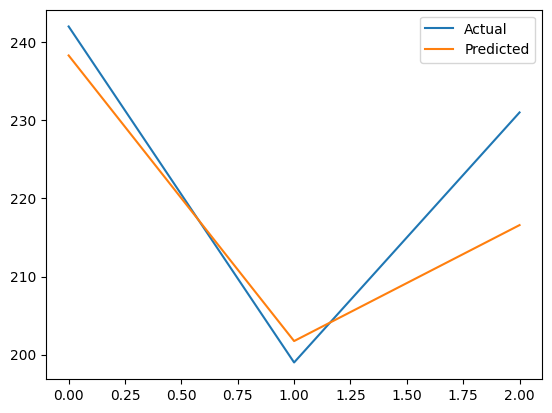

In [172]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [173]:
r2 = r2_score(y_true, y_pred)
print("R^2 Score:", r2)

R^2 Score: 0.7703829017533599


In [174]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_true, y_pred, squared=False)
print("rmsw:", rmse)

rmsw: 8.739905873828521


In [175]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_true, y_pred)
print("mape:", mape)

mape: 0.03050650222115289
